# Denoising Diffusion Probabilistic Models (DDPM)
The following notebook describes how to implement a DDPM. By following this notebook, you should be able to implement your own DDPM on your own dataset.

Inspiration and sources:
https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=buW6BaNga-XH

## Init packages
First we need to import some packages. These packages will be used throughout the notebook.

In [1]:
from torch.utils.data import  DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from typing import Literal

## Flags
The following section defines some magic variables. I have decided to save them all here, so they can be easily modified without having to scroll through the entire code. Whenever a flag variable is used a comment will highligt it so you can scoll up and change the value to fit your usecase, 

In [2]:
DATA_PATH = "data/butterflies"
IMG_SIZE = 64 #The width and height of the images
BATCH_SIZE = 8 #The batch size used durring training
TIMESTEPS = 300
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Data Load & Transformation
Now we are ready to load our dataset. It is assumed that you have a folder with all of the images. We could use a predefined dataset from a package, like <a href="https://pytorch.org/vision/main/generated/torchvision.datasets.StanfordCars.html">StanfordCars</a>. Since you might want to use your own dataset, we are going to assume that this is not an option. If you plan on using a predefined dataset, you kan skip the data load section.

In this notebook, we are going to use the <a href="https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species">Butterfly & Moths Image Classification 100 species</a> dataset. There are multiple different ways to download the dataset, since it is hoset on kaggle. We are just going to manually download the zip file, and extract the contents in a folder called "data".

The structure should look like this:

```
root/
    data/
        butterflies/
            train/
            test/
            valid/
```

Since we are trying to create a DDPM, we are not going to care about train, val and test split. We are just going to use the entire dataset durring training. We do this by creating a dataloader. We do this so we are able to easily get a batch of data, and to keep track of batches we have already processed.



The following flags will be set in this section:
- ```IMG_SIZE``` to hold the value of the desired image height and width.
- ```BATCH_SIZE``` to hold the value of the desired batch size.
- ```DATA_PATH``` to hold the value of the path to the data.

We will perform some basic transformations to the images:

- Resize: the images needs to be the same size. 
- RandomHorizontalFlip: Randomly flip the images by the horizontal axis
- Normalization: the images are normalized to be between -1 and 1 for all channels

In [3]:
def load_transformed_dataset(
        path_to_data:str,
        image_size:tuple[int,int]=(IMG_SIZE,IMG_SIZE),
        batch_size:int=BATCH_SIZE
        ):
    """
    Loads and transforms a dataset of images from a specified directory, returning a dataset object.

    Parameters
    -----------
        path_to_data : str
            The root directory path where images are stored.
        image_size : tuple[int, int], optional
            The desired size to which each image will be resized. 
            Default is (IMG_SIZE, IMG_SIZE).
        batch_size : int, optional
            The desired batch size. 
            Default is BATCH_SIZE.

    Returns
    ---------
        torchvision.datasets.ImageFolder: A dataset object containing the transformed images.

    """
    data_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ])
    dataset = datasets.ImageFolder(root=path_to_data, transform=data_transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return dataloader
dataloader = load_transformed_dataset(DATA_PATH)

Lets take a look at one of the data samples. We are going to be plotting images quite a few times, so to make life easier, we lets create a general function we can use:

In [4]:
def show_tensor_image(image: torch.Tensor, ax:matplotlib.axes.Axes=None):
    """
    Displays a tensor image. If an axis is provided, the image is plotted on that axis;
    otherwise, it is plotted in a new figure.

    Parameters
    -----------
    image : torch.Tensor
        The image tensor to be displayed.
    ax : matplotlib.axes.Axes, optional
        The axis on which to plot the image. If None, the image is plotted in a new figure.

    """
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),       # Scale back to [0, 1]
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.0),         # Scale to [0, 255]
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)), # Convert to uint8
        transforms.ToPILImage(),
    ])

    # Take first image of batch if batch dimension is present
    if len(image.shape) == 4:
        image = image[0, :, :, :]

    image = reverse_transforms(image)

    if ax is not None:
        ax.imshow(image)
    else:
        plt.imshow(image)
        plt.show()

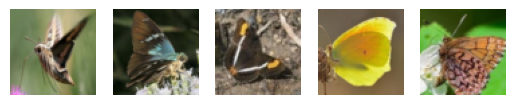

In [5]:
num_images = 5
fig,ax = plt.subplots(1,num_images)
for i in range(num_images):
    image = next(iter(dataloader))[0]
    ax[i].axis('off')
    show_tensor_image(image, ax=ax[i])

## The forward process = Noise scheduler
Now that we have a dataloader, we can start defining the forward process

The following flags will be set in this section:
- ```TIMESTEPS``` to hold the value of the desired number of timesteps.

Read more about why you might want to use the cosine scheduler here: https://proceedings.mlr.press/v139/nichol21a.html

In [6]:
class ForwardProcess:
    def __init__(self,scheduler:Literal['linear', 'cosine'] = 'cosine') -> None:
        schedulers = {
            'linear':self.linear_schedule,
            'cosine':self.cosine_schedule}
        self.betas = schedulers[scheduler](timesteps=TIMESTEPS)
        alphas = 1. - self.betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
        self.sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
        self.posterior_variance = self.betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    def linear_schedule(self,timesteps:int)->torch.tensor:
        """
        The linear scheduler

        Parameters
        -----------
        timesteps : int
            The number of timesteps
        Returns
        ---------
        torch.tensor: The beta values

        """
        beta_start = 1e-4
        beta_end = 0.02
        betas = torch.linspace(beta_start, beta_end, timesteps)
        betas = torch.cat((torch.tensor([0]), betas))
        return betas

    def cosine_schedule(self,timesteps:int, s:float=0.008)->torch.tensor:
        """
        The cosine scheduler

        Parameters
        -----------
        timesteps : int
            The number of timesteps
        Returns
        ---------
        torch.tensor: The beta values

        """
        def f(t):
            return torch.cos((t / timesteps + s) / (1 + s) * 0.5 * torch.pi) ** 2
        x = torch.linspace(0, timesteps, timesteps + 1)
        alphas_cumprod = f(x) / f(torch.tensor([0]))
        betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
        betas = torch.clip(betas, 0.0001, 0.999)
        return betas
    
    def get_index_from_list(self,vals:torch.tensor, t:torch.tensor, x_shape:torch.Size):
        """ 
        Returns a specific index t of a passed list of values vals
        while considering the batch dimension.
        """
        batch_size = t.shape[0]
        out = vals.gather(-1, t.cpu())
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
    
    def forward_diffusion_sample(self,x_0:torch.tensor, t:torch.tensor, device:str="cpu"):
        """ 
        Takes an image and a timestep as input and 
        returns the noisy version of it
        """
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(
            self.sqrt_one_minus_alphas_cumprod, t, x_0.shape
        )
        # mean + variance
        return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
        + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)
    
scheduler = ForwardProcess("cosine")

Lets visualize the noise in the image

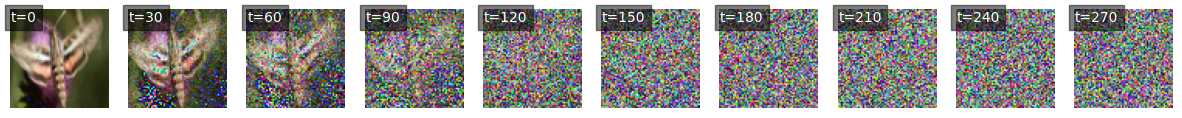

In [7]:
image = next(iter(dataloader))[0]
num_images = 10
fig,ax = plt.subplots(1,num_images,figsize=(15, 5))
stepsize = int(TIMESTEPS/num_images)
for i,idx in enumerate(range(0, TIMESTEPS, stepsize)):
    t = torch.Tensor([idx]).type(torch.int64)
    img, noise = scheduler.forward_diffusion_sample(image, t)
    ax[i].axis('off')
    ax[i].text(0, 0, f"t={int(t)}", color='white', va='top', ha='left', bbox=dict(facecolor='black', alpha=0.5))
    show_tensor_image(img, ax=ax[i])

## Model Definition

In [8]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  62438883


The following flags will be set in this section:
- ```DEVICE``` to hold the value of the desired number of timesteps.

In [9]:
def get_loss(scheduler,model, x_0, t):
    x_noisy, noise = scheduler.forward_diffusion_sample(x_0, t, DEVICE)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [10]:
@torch.no_grad()
def sample_timestep(scheduler,x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = scheduler.get_index_from_list(scheduler.betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = scheduler.get_index_from_list(
        scheduler.sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = scheduler.get_index_from_list(scheduler.sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = scheduler.get_index_from_list(scheduler.posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(scheduler):
    img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=DEVICE)
    num_images = 10
    fig,ax = plt.subplots(1,num_images,figsize=(15, 5))
    stepsize = int(TIMESTEPS/num_images)
    for i in range(0,TIMESTEPS)[::-1]:
        t = torch.full((1,), i, device=DEVICE, dtype=torch.long)
        img = sample_timestep(scheduler,img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt_idx = int((TIMESTEPS-i)/stepsize)-1
            ax[plt_idx].axis('off')
            ax[plt_idx].text(0, 0, f"t={int(t)}", color='white', va='top', ha='left', bbox=dict(facecolor='black', alpha=0.5))
            show_tensor_image(img.detach().cpu(), ax=ax[plt_idx])


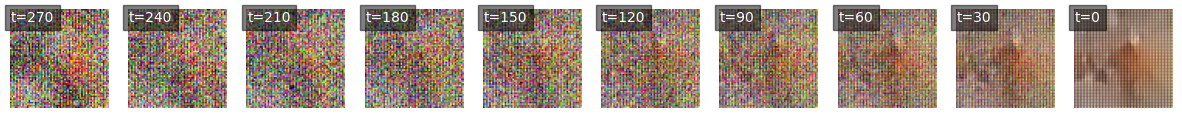

In [15]:


sample_plot_image(scheduler)

In [17]:
from torch.optim import Adam

model.to(DEVICE)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    loss = 0
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()
      t = torch.randint(0, TIMESTEPS, (BATCH_SIZE,), device=DEVICE).long()
      loss = get_loss(scheduler,model, batch[0], t)
      loss.backward()
      optimizer.step()
      loss+=loss.item()

      if step % 5 == 0:
        print(f"Epoch {epoch} | step {step:03d}/{len(dataloader)} Loss: {loss/(step+1)} ",end="\r")
    print(f"Epoch {epoch} Loss: {loss/(step+1)}",end="\n")
    sample_plot_image(scheduler)

KeyboardInterrupt: 